# 初始spark設定(每台不同)

In [1]:
import os
import sys
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH/lib/spark/'

In [2]:
import findspark
findspark.init()

# 欄位資訊

In [3]:
with open("col_info.txt", "r") as f:
    head = f.readline()
    col_info = [ line.strip().split(" ") for line in f.read().split("\n")]

In [4]:
col_info[:5]

[['0', 'Year', 'int', '飛行日期_年', 'X'],
 ['1', 'Month', 'int', '飛行日期_月', 'O', '一月和十二月特別容易取消班機'],
 ['2', 'DayofMonth', 'int', '飛行日期_日', 'O', '11號和13號', '特別容易取消班機'],
 ['3', 'DayOfWeek', 'int', '飛行日期_星期', 'O', '星期二特別容易取消班機,星期日最不容易取消班機'],
 ['4', 'DepTime', 'str', '飛行時間_起飛時間', 'X', "如果班機取消,這個值必為'NA',不可選"]]

# 讀取資料

In [5]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('yarn')
spark = SparkSession(sc)

In [6]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [7]:
SELECED_COLS_CATAG = ['UniqueCarrier', 'Origin', 'Dest', 'FlightNum']
SELECED_COLS_FLOAT = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'Distance']
LABEL_COL = 'Cancelled'

In [8]:
from pyspark.sql.types import *

schema = StructType([
    StructField(ci[1], IntegerType() if ci[2]=='int' else StringType() , False) for ci in col_info ])

df_train = sqlContext.read.format('com.databricks.spark.csv') \
        .options(header='true', inferschema='true') \
        .schema(schema) \
        .load('2000.csv') \
        .select(SELECED_COLS_CATAG+SELECED_COLS_FLOAT+[LABEL_COL]) #截取部分欄位之資料

In [9]:
print(df_train.count())
df_train = df_train.na.drop()
print(df_train.count())

5683047
5683047


In [10]:
df_train.createOrReplaceTempView("df_train")

In [11]:
df_train.take(1)

[Row(UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=28, DayOfWeek=5, CRSDepTime=1647, Distance=1587, Cancelled=0)]

# 資料前處理 新增欄位

In [12]:
from pyspark.sql import Column
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.functions import sin, cos
from numpy import pi

In [13]:
new_COLS_CATAG = [] #init
new_COLS_FLOAT = [] #init

### Distance

In [14]:
spark.sql("select max(Distance) from df_train").show()

+-------------+
|max(Distance)|
+-------------+
|         4962|
+-------------+



In [15]:
udf_Distance_Norm = UserDefinedFunction(lambda x: x/4962, FloatType())

In [16]:
df_train = df_train.withColumn("Distance_norm", udf_Distance_Norm("Distance"))
df_train.take(1)

[Row(UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=28, DayOfWeek=5, CRSDepTime=1647, Distance=1587, Cancelled=0, Distance_norm=0.3198307156562805)]

In [17]:
new_COLS_FLOAT.append("Distance_norm")

### Month, DayofMonth, DayOfWeek, CRSDepTime

In [18]:
udf_Time_ToFloat = UserDefinedFunction(lambda x: ((x//100)/24+(1/24)*(x%100)/60)*2*pi, FloatType())
udf_Month_ToFloat = UserDefinedFunction(lambda x: x/12*2*pi, FloatType())
udf_DayofMonth_ToFloat = UserDefinedFunction(lambda x: x/31*2*pi, FloatType())
udf_DayOfWeek_ToFloat = UserDefinedFunction(lambda x: x/7*2*pi, FloatType())

In [19]:
df_train = df_train.withColumn("CRSDepTime_f", udf_Time_ToFloat("CRSDepTime"))
df_train = df_train.withColumn("Month_f", udf_Month_ToFloat("Month"))
df_train = df_train.withColumn("DayofMonth_f", udf_DayofMonth_ToFloat("DayofMonth"))
df_train = df_train.withColumn("DayOfWeek_f", udf_DayOfWeek_ToFloat("DayOfWeek"))
for col_name in ['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime']:
    df_train = df_train.withColumn(col_name+"_sin", sin(col_name+"_f")) 
    new_COLS_FLOAT.append(col_name+"_f")
    new_COLS_FLOAT.append(col_name+"_sin")
df_train.take(1)

[Row(UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=28, DayOfWeek=5, CRSDepTime=1647, Distance=1587, Cancelled=0, Distance_norm=0.3198307156562805, CRSDepTime_f=4.393866539001465, Month_f=0.5235987901687622, DayofMonth_f=5.675135135650635, DayOfWeek_f=4.48798942565918, Month_sin=0.5000000126183913, DayofMonth_sin=-0.5712681990994033, DayOfWeek_sin=-0.974927894498283, CRSDepTime_sin=-0.9496991722700603)]

### FlightNum

In [20]:
sql_text = """select X.{colname} , X.C as Qty, round(X.C/Y.C*100,2) as Ratio
              from (select {colname}, count({colname}) as C from df_train where Cancelled=1 group by {colname}) X 
              join (select {colname}, count({colname}) as C from df_train group by {colname}) Y on X.{colname}=Y.{colname}
            order by Ratio DESC"""

In [21]:
df_pd_FlightNum = spark.sql(sql_text.format(colname="FlightNum")).toPandas()

In [22]:
df_pd_FlightNum.head()

,FlightNum,Qty,Ratio
0,2343,21,30.00
1,2961,14,21.88
2,1365,71,19.51
3,2883,45,17.37
4,6493,6,16.67


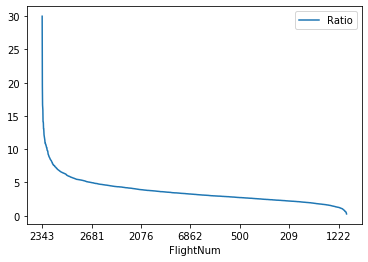

In [23]:
df_pd_FlightNum.plot('FlightNum','Ratio')

In [24]:
catg_selected_FlightNums = list(df_pd_FlightNum[df_pd_FlightNum.Ratio>7.0].FlightNum)
print(len(catg_selected_FlightNums))

153


In [25]:
def MarkElse(col_name, catg_selected):
    global df_train, new_COLS_CATAG
    # 把影響比較不顯著的值改成 'ELSE'
    print(f"修改前 [{col_name}] 種類數量:", df_train.select(col_name).distinct().count())
    udf_MarkElse = UserDefinedFunction(lambda x: x if x in catg_selected else "ELSE", StringType())
    df_train = df_train.withColumn(col_name+"_m", udf_MarkElse(col_name))
    new_COLS_CATAG.append(col_name+"_m")
    print(f"修改後 [{col_name+'_m'}] 種類數量:", df_train.select(col_name+"_m").distinct().count())

In [26]:
MarkElse("FlightNum", catg_selected_FlightNums)

修改前 [FlightNum] 種類數量: 3131
修改後 [FlightNum_m] 種類數量: 154


### Origin

In [27]:
df_pd_Origin = spark.sql(sql_text.format(colname="Origin")).toPandas()

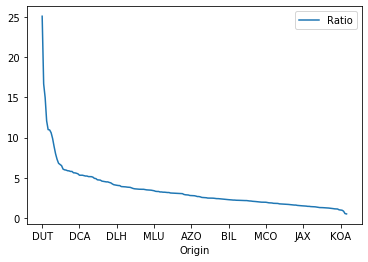

In [28]:
df_pd_Origin.plot('Origin','Ratio')

In [29]:
catg_selected_Origins =  list(df_pd_Origin[df_pd_Origin.Ratio>5.0].Origin)
print(len(catg_selected_Origins))

35


In [30]:
MarkElse("Origin", catg_selected_Origins)

修改前 [Origin] 種類數量: 206
修改後 [Origin_m] 種類數量: 36


### Dest

In [31]:
df_pd_Dest = spark.sql(sql_text.format(colname="Dest")).toPandas()

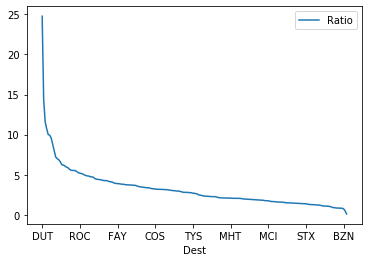

In [32]:
df_pd_Dest.plot('Dest','Ratio')

In [33]:
catg_selected_Dests =  list(df_pd_Dest[df_pd_Dest.Ratio>5.0].Dest)
print(len(catg_selected_Dests))

28


In [34]:
MarkElse("Dest", catg_selected_Dests)

修改前 [Dest] 種類數量: 206
修改後 [Dest_m] 種類數量: 29


### UniqueCarrier

In [35]:
df_pd_UniqueCarrier = spark.sql(sql_text.format(colname="UniqueCarrier")).toPandas()

In [36]:
df_pd_UniqueCarrier.shape

(11, 3)

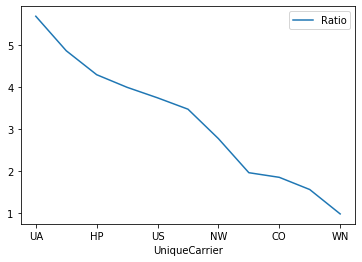

In [37]:
df_pd_UniqueCarrier.plot('UniqueCarrier','Ratio')

In [38]:
print("此欄位不修改")
new_COLS_CATAG.append('UniqueCarrier')

此欄位不修改


In [39]:
df_train.createOrReplaceTempView("df_train")
df_train.take(1)

[Row(UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=28, DayOfWeek=5, CRSDepTime=1647, Distance=1587, Cancelled=0, Distance_norm=0.3198307156562805, CRSDepTime_f=4.393866539001465, Month_f=0.5235987901687622, DayofMonth_f=5.675135135650635, DayOfWeek_f=4.48798942565918, Month_sin=0.5000000126183913, DayofMonth_sin=-0.5712681990994033, DayOfWeek_sin=-0.974927894498283, CRSDepTime_sin=-0.9496991722700603, FlightNum_m='ELSE', Origin_m='ELSE', Dest_m='ELSE')]

### class_weight

In [90]:
weightNonCanceled = df_train.where("Cancelled=1").count()/df_train.count()
print("班機取消的比例: ", weightNonCanceled )

班機取消的比例:  0.03299110494775074


In [91]:
udf_weight_class = UserDefinedFunction(lambda x: 1-weightNonCanceled if x==1 else weightNonCanceled , FloatType())

In [92]:
df_train = df_train.withColumn("class_weight", udf_weight_class("Cancelled"))

In [93]:
df_train.where("Cancelled=1").take(1)

[Row(UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=30, DayOfWeek=7, CRSDepTime=1647, Distance=1587, Cancelled=1, Distance_norm=0.3198307156562805, CRSDepTime_f=4.393866539001465, Month_f=0.5235987901687622, DayofMonth_f=6.080502033233643, DayOfWeek_f=6.2831854820251465, Month_sin=0.5000000126183913, DayofMonth_sin=-0.2012983995478517, DayOfWeek_sin=1.7484556000744883e-07, CRSDepTime_sin=-0.9496991722700603, FlightNum_m='ELSE', Origin_m='ELSE', Dest_m='ELSE', class_weight=0.9670088887214661)]

In [94]:
df_train.count()

5683047

# 補值確認

# 建立模型

ref: https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/

ref: https://spark.apache.org/docs/latest/ml-tuning.html

In [107]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [96]:
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("error")
    for c in new_COLS_CATAG
]
encoder = OneHotEncoderEstimator(
        inputCols=[indexer.getOutputCol() for indexer in indexers],
        outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
)
vectorAssembler = VectorAssembler(
    inputCols=encoder.getOutputCols()+new_COLS_FLOAT, 
    outputCol="features"
)

In [97]:
pipeline = Pipeline(stages=indexers+[encoder, vectorAssembler]).fit(df_train)
allData = pipeline.transform(df_train)

In [214]:
allData.cache()
trainingData, valData = allData.randomSplit([0.8,0.2], seed=1234) # need to ensure same split for each time
print("Distribution of Pos and Neg in trainingData is: ", trainingData.groupBy(LABEL_COL).count().take(3))

Distribution of Pos and Neg in trainingData is:  [Row(Cancelled=1, count=150175), Row(Cancelled=0, count=4395222)]


In [99]:
lr = LogisticRegression(maxIter=10).setWeightCol("class_weight").setLabelCol(LABEL_COL).setFeaturesCol("features")

In [108]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [1.0, 0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

evaluator = BinaryClassificationEvaluator(
    labelCol=LABEL_COL, 
    rawPredictionCol="prediction", 
    metricName="areaUnderROC")

cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # use 3+ folds in practice

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [110]:
model = cv.fit(trainingData)

In [211]:
bestModel = model.bestModel #取得最佳模型

In [212]:
java_model =bestModel._java_obj #印出最佳參數
{param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]}

{'regParam': 0.01, 'fitIntercept': True, 'elasticNetParam': 0.0}

In [153]:
cv.save("cv_lr_2000")

# 驗證模型

In [215]:
predicted_train = model.transform(valData).select('probability', LABEL_COL, "prediction")

In [216]:
tp = float(predicted_train.filter(f"prediction == 1.0 AND {LABEL_COL} == 1").count())
fp = float(predicted_train.filter(f"prediction == 1.0 AND {LABEL_COL} == 0").count())
tn = float(predicted_train.filter(f"prediction == 0.0 AND {LABEL_COL} == 0").count())
fn = float(predicted_train.filter(f"prediction == 0.0 AND {LABEL_COL} == 1").count())
r = tp / (tp + fn)
p =  tp / (tp + fp)
f1 = 2/(1/r+1/p)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", p ),
 ("Recall", r),
 ("F1-Score", r)], ["metric", "value"])
metrics.show()

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            23273.0|
|       FP|           388199.0|
|       TN|           712136.0|
|       FN|            14042.0|
|Precision|0.05656034918536377|
|   Recall| 0.6236902050113895|
| F1-Score| 0.6236902050113895|
+---------+-------------------+



In [240]:
result = predicted_train.select('probability', LABEL_COL).collect()

In [241]:
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in result]

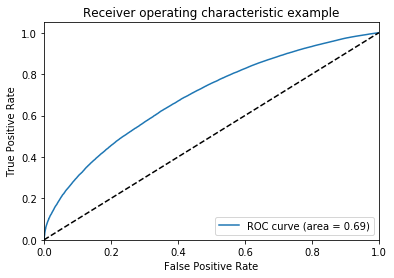

In [242]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()